In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


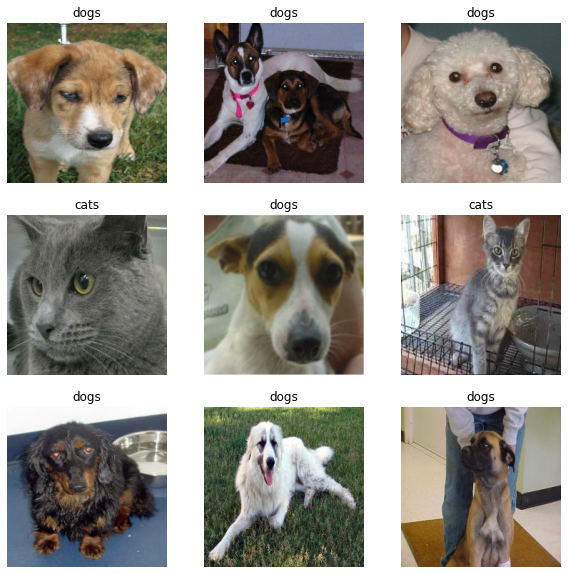

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
#split valdiation dataset to test set

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [12]:
IMG_SHAPE

(224, 224, 3)

In [13]:
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)

Epoch 1/15
63/63 [==============================] - 107s 2s/step - loss: 0.8486 - accuracy: 0.5335 - val_loss: 0.7669 - val_accuracy: 0.5260
Epoch 2/15
63/63 [==============================] - 107s 2s/step - loss: 0.8278 - accuracy: 0.5025 - val_loss: 0.7577 - val_accuracy: 0.5124
Epoch 3/15
63/63 [==============================] - 108s 2s/step - loss: 0.8139 - accuracy: 0.5105 - val_loss: 0.7512 - val_accuracy: 0.5396
Epoch 4/15
63/63 [==============================] - 108s 2s/step - loss: 0.8044 - accuracy: 0.5180 - val_loss: 0.7474 - val_accuracy: 0.5173
Epoch 5/15
63/63 [==============================] - 108s 2s/step - loss: 0.7955 - accuracy: 0.5050 - val_loss: 0.7407 - val_accuracy: 0.4913
Epoch 6/15
63/63 [==============================] - 111s 2s/step - loss: 0.7868 - accuracy: 0.4960 - val_loss: 0.7396 - val_accuracy: 0.5210
Epoch 7/15
63/63 [==============================] - 107s 2s/step - loss: 0.7803 - accuracy: 0.4985 - val_loss: 0.7357 - val_accuracy: 0.5099
Epoch 8/15
63

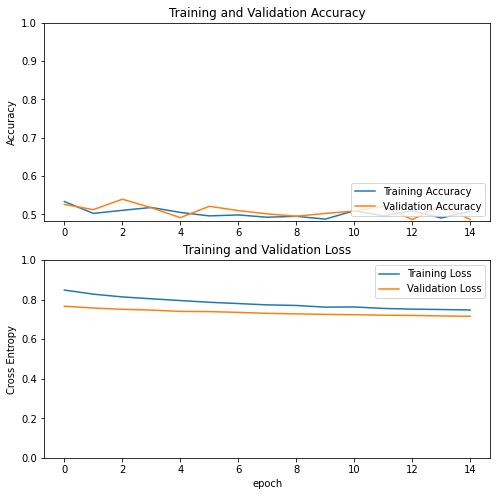

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
model.save('cats.h5')

In [21]:
import os
print(str(os.path.getsize('./cats.h5')/1000000) + 'MB')

9.36936MB


**Fine Tuning**

In [22]:
base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [25]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [26]:
len(model.trainable_variables)

58

In [27]:
history_fine = model.fit(train_dataset,
                         epochs=20,
                         validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 157s 2s/step - loss: 0.7168 - accuracy: 0.4825 - val_loss: 0.6982 - val_accuracy: 0.4295
Epoch 2/20
63/63 [==============================] - 156s 2s/step - loss: 0.6952 - accuracy: 0.4995 - val_loss: 0.6934 - val_accuracy: 0.5111
Epoch 3/20
63/63 [==============================] - 156s 2s/step - loss: 0.6932 - accuracy: 0.5480 - val_loss: 0.6932 - val_accuracy: 0.5285
Epoch 4/20
63/63 [==============================] - 155s 2s/step - loss: 0.6932 - accuracy: 0.5295 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 5/20
63/63 [==============================] - 154s 2s/step - loss: 0.6931 - accuracy: 0.5420 - val_loss: 0.6931 - val_accuracy: 0.5037
Epoch 6/20
63/63 [==============================] - 154s 2s/step - loss: 0.6931 - accuracy: 0.5375 - val_loss: 0.6931 - val_accuracy: 0.5099
Epoch 7/20
63/63 [==============================] - 154s 2s/step - loss: 0.6931 - accuracy: 0.5200 - val_loss: 0.6931 - val_accuracy: 0.5285
Epoch 8/20
63